# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: TC5035.10 Proyecto Integrador**
### Tecnológico de Monterrey
### Dra. Grettel Barceló Alonso 
### Dr. Luis Eduardo Falcón Morales

## **Avance 5. Modelo Final**


**Nombres y matrículas de los integrantes del equipo:**
| Nombre | Matrícula |
| --- | --- |
| Rodrigo López Aguilera | A01793071 |
| Alejandra Mendoza Flores | A01793032 |
| Diego Carrera Nicholls | A00464290 |

In [83]:
from sklearn.experimental import enable_halving_search_cv # noqa

In [103]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.gridspec import GridSpec

from sklearn.metrics import (
    confusion_matrix,
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
    brier_score_loss,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
)

from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

from xgboost import XGBClassifier

from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [2]:
# Desplegando la matriz de confusión:
# (etiquetas_reales, etiquetas_de_predicciones)
def mi_cm(yreal, ypred):
    cm = confusion_matrix(yreal, ypred)

    txt = [
        "Verdaderos Negativos",
        "Falsos Positivos",
        "Falsos Negativos",
        "Verdaderos Positivos",
    ]
    vf = ["( VN )", "( FP )", "( FN )", "( VP )"]
    frecuencia = ["{0:0.0f}".format(value) for value in cm.flatten()]
    porcentaje = ["{0:.1%}".format(value) for value in cm.flatten() / np.sum(cm)]

    labels = [
        f"{v1}\n{v2}\n{v3}\n{v4}"
        for v1, v2, v3, v4 in zip(txt, vf, frecuencia, porcentaje)
    ]
    labels = np.asarray(labels).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(cm, annot=labels, fmt="", cmap="Blues", cbar=False)
    ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
    plt.show()

In [3]:
def plot_learning_curve(train_sizes, train_scores, test_scores, title, metric, ylim=None):
    plt.figure(figsize=(10, 7))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(f"{metric} Score")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="b",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.plot(
        train_sizes, train_scores_mean, "o-", color="b", label="Training score"
    )
    plt.plot(
        train_sizes, test_scores_mean, "+--", color="r", label="Cross-validation score"
    )
    plt.legend(loc="best")
    return plt

In [4]:
RANDOM_STATE = 42

In [5]:
pd.options.display.float_format = "{:,.4f}".format

In [6]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

In [24]:
steps = np.linspace(0.1, 1.0, 25)

In [7]:
cleaned_df = pd.read_csv("data/pickwin-active-users.csv")
clean_df = cleaned_df.drop(columns=["days_since_registration"])
clean_df = clean_df.dropna()
clean_df = clean_df.drop_duplicates()
clean_df = clean_df[(clean_df.T != 0).any()]
# feature generation
clean_df["net_winnings"] = clean_df.apply(
    lambda x: x["net_win"] if x["net_win"] > 0 else 0, axis=1
)
clean_df["net_losses"] = clean_df.apply(
    lambda x: x["net_win"] if x["net_win"] < 0 else 0, axis=1
).abs()
# clean_df["winner"] = np.where(clean_df["net_win"] > 0, 1, 0)

# relation of winning bets to total bets
clean_df["win_ratio"] = clean_df["winning_bets"] / clean_df["total_bets"]
# relation of risked money to total bets
clean_df["risk_per_bet"] = clean_df["total_risk"] / clean_df["total_bets"]
# relation of net winnings to total bets
clean_df["net_winnings_per_bet"] = clean_df["net_winnings"] / clean_df["total_bets"]
# relation of net losses to total bets
clean_df["net_losses_per_bet"] = clean_df["net_losses"] / clean_df["total_bets"]

In [8]:
X, y = clean_df.drop(["churned"], axis=1), clean_df["churned"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=RANDOM_STATE, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11764, 16) (6335, 16) (11764,) (6335,)


## Random Forest

In [86]:
# optimización de hiperparámetros
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
rfc_pipeline = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RobustScaler(),
    PowerTransformer("yeo-johnson"),
    PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver="full"),
    rfc,
)

param_grid = {
    "randomforestclassifier__ccp_alpha": [0.001, 0.01, 0.1, 0.99],
    "randomforestclassifier__criterion": ["gini", "entropy", "log_loss"],
    "randomforestclassifier__max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "randomforestclassifier__min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "randomforestclassifier__class_weight": ["balanced", None, "balanced_subsample"],
}

rfc_grid_search = RandomizedSearchCV(rfc_pipeline, param_grid, scoring="recall", cv=kfold, n_jobs=-1, verbose=1)
rfc_grid_result = rfc_grid_search.fit(X_train, y_train)

print(f"Best: {rfc_grid_result.best_score_} using {rfc_grid_result.best_params_}")

Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best: 0.8348289475428897 using {'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__max_depth': 9, 'randomforestclassifier__criterion': 'log_loss', 'randomforestclassifier__class_weight': None, 'randomforestclassifier__ccp_alpha': 0.001}


In [87]:
best_rfc_model = rfc_grid_search.best_estimator_
best_rfc_model.fit(X_train, y_train)
y_pred = best_rfc_model.predict(X_test)

print(recall_score(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

0.8198198198198198
                   pre       rec       spe        f1       geo       iba       sup

          0       0.23      0.72      0.82      0.35      0.77      0.58       452
          1       0.97      0.82      0.72      0.89      0.77      0.59      5883

avg / total       0.92      0.81      0.72      0.85      0.77      0.59      6335



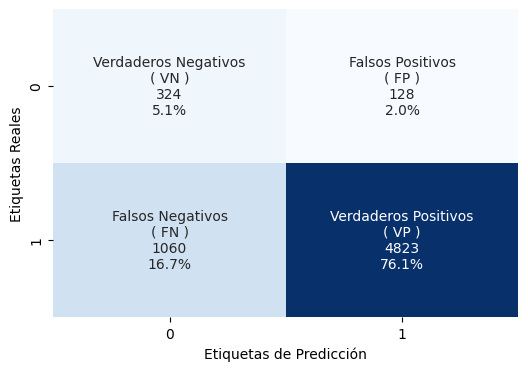

In [88]:
mi_cm(y_test, y_pred)

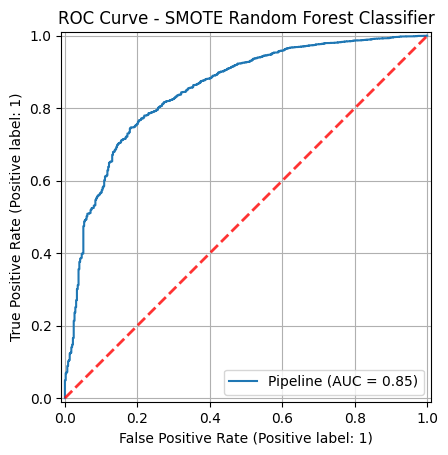

In [89]:
disp = RocCurveDisplay.from_estimator(best_rfc_model, X_test, y_test)
disp.ax_.grid(True)
disp.ax_.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
# title
disp.ax_.set_title("ROC Curve - SMOTE Random Forest Classifier")
plt.show()

In [90]:
train_sizes, train_scores, test_scores = learning_curve(
    best_rfc_model,
    X_train,
    y_train,
    train_sizes=steps,
    cv=kfold,
    scoring="f1",
    n_jobs=-1
)

<module 'matplotlib.pyplot' from '/home/chango/proyecto-integrador/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

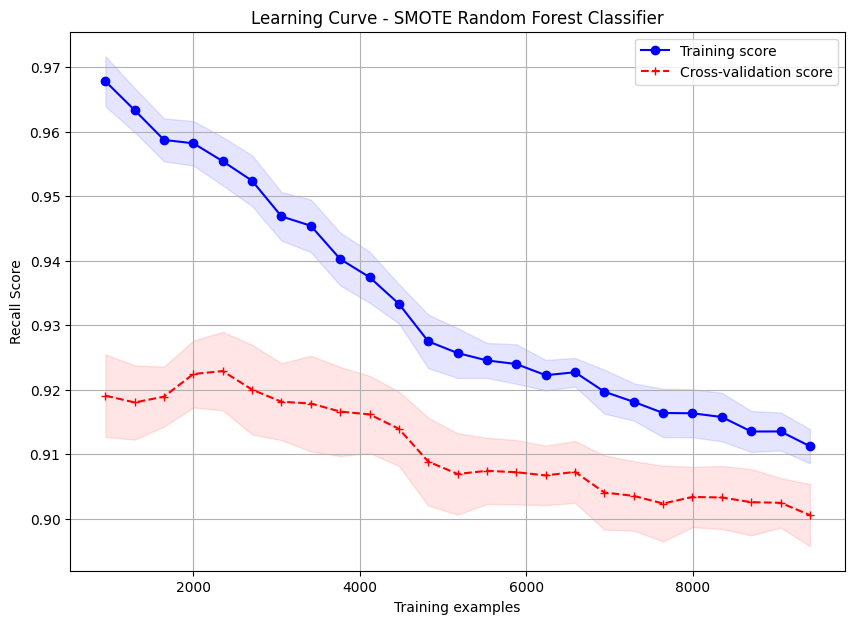

In [91]:
plot_learning_curve(
    train_sizes,
    train_scores,
    test_scores,
    "Learning Curve - SMOTE Random Forest Classifier",
    "Recall",
)

## XGBoost

In [35]:
param_grid = {
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.1, 0.01, 0.001],
    'xgbclassifier__subsample': [0.5, 0.7, 1]
}

xgb = XGBClassifier()
xgb_pipeline = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RobustScaler(),
    PowerTransformer("yeo-johnson"),
    PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver='full'),
    xgb
)

xgb_grid_search = GridSearchCV(xgb_pipeline, param_grid, scoring='recall', cv=kfold, n_jobs=-1, verbose=1)
xgb_grid_result = xgb_grid_search.fit(X_train, y_train)

print(f"Best: {xgb_grid_result.best_score_} using {xgb_grid_result.best_params_}")

Fitting 15 folds for each of 27 candidates, totalling 405 fits
Best: 0.8618286258228809 using {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 7, 'xgbclassifier__subsample': 0.7}


In [36]:
best_xgb_model = xgb_grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)
y_pred = best_xgb_model.predict(X_test)

print(recall_score(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

0.8533061363250043
                   pre       rec       spe        f1       geo       iba       sup

          0       0.25      0.64      0.85      0.36      0.74      0.53       452
          1       0.97      0.85      0.64      0.91      0.74      0.56      5883

avg / total       0.92      0.84      0.65      0.87      0.74      0.56      6335



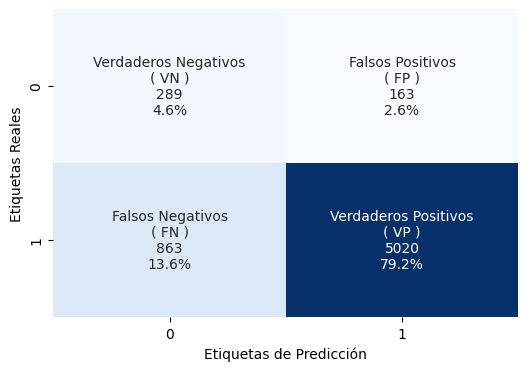

In [37]:
mi_cm(y_test, y_pred)

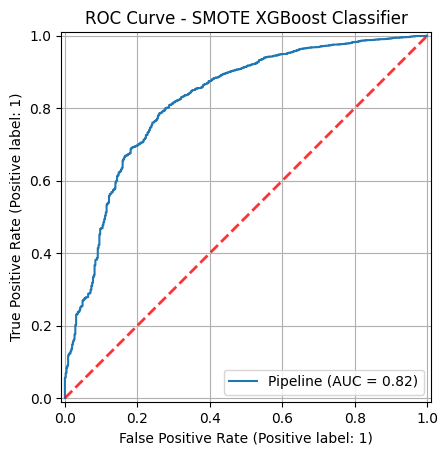

In [38]:
disp = RocCurveDisplay.from_estimator(best_xgb_model, X_test, y_test)
disp.ax_.grid(True)
disp.ax_.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
# title
disp.ax_.set_title("ROC Curve - SMOTE XGBoost Classifier")
plt.show()

In [45]:
train_sizes, train_scores, test_scores = learning_curve(
    best_xgb_model,
    X_train,
    y_train,
    train_sizes=steps,
    cv=kfold,
    scoring="recall",
    n_jobs=-1
)

<module 'matplotlib.pyplot' from '/home/chango/proyecto-integrador/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

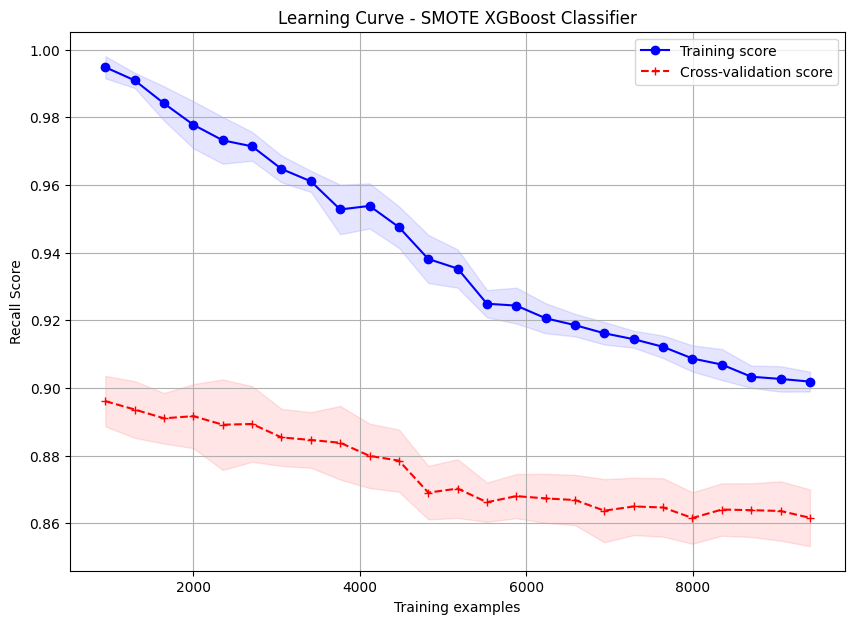

In [46]:
plot_learning_curve(
    train_sizes,
    train_scores,
    test_scores,
    "Learning Curve - SMOTE XGBoost Classifier",
    "Recall"
)

## Gradient Boosting

In [41]:
gb_base_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_pipeline = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RobustScaler(),
    PowerTransformer("yeo-johnson"),
    PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver='full'),
    gb_base_model,
)

param_grid = {
    "gradientboostingclassifier__n_estimators": [100, 200, 300, 1000],
    "gradientboostingclassifier__learning_rate": [0.001, 0.01, 0.1, 1],
    "gradientboostingclassifier__max_depth": [1, 5, 10, 50, 100, None],
}

gb_grid_search = RandomizedSearchCV(gb_pipeline, param_grid, scoring="recall", cv=5, n_jobs=-1)
gb_grid_result = gb_grid_search.fit(X_train, y_train)

print(f"Best: {gb_grid_result.best_score_} using {gb_grid_result.best_params_}")


Best: 0.8644520047483362 using {'gradientboostingclassifier__n_estimators': 200, 'gradientboostingclassifier__max_depth': 10, 'gradientboostingclassifier__learning_rate': 1}


In [42]:
best_gb_model = gb_grid_search.best_estimator_
best_gb_model.fit(X_train, y_train)
y_pred = best_gb_model.predict(X_test)

print(recall_score(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

0.8551759306476288
                   pre       rec       spe        f1       geo       iba       sup

          0       0.24      0.60      0.86      0.34      0.71      0.50       452
          1       0.96      0.86      0.60      0.91      0.71      0.52      5883

avg / total       0.91      0.84      0.61      0.87      0.71      0.52      6335



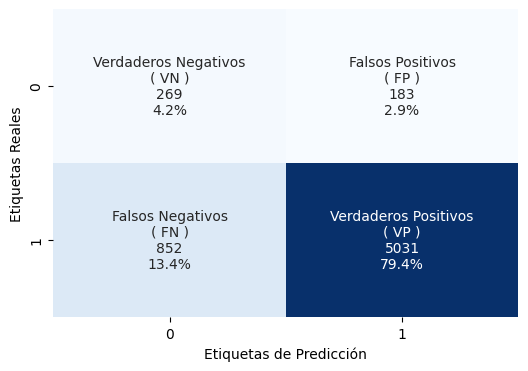

In [43]:
mi_cm(y_test, y_pred)

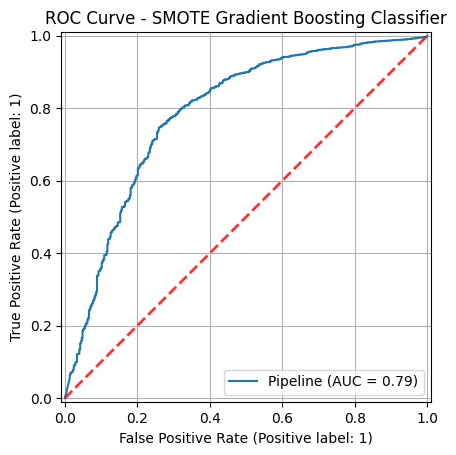

In [44]:
disp = RocCurveDisplay.from_estimator(best_gb_model, X_test, y_test)
disp.ax_.grid(True)
disp.ax_.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
# title
disp.ax_.set_title("ROC Curve - SMOTE Gradient Boosting Classifier")
plt.show()

In [47]:
train_sizes, train_scores, test_scores = learning_curve(
    best_gb_model,
    X_train,
    y_train,
    train_sizes=steps,
    cv=kfold,
    scoring="recall",
    n_jobs=-1
)

<module 'matplotlib.pyplot' from '/home/chango/proyecto-integrador/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

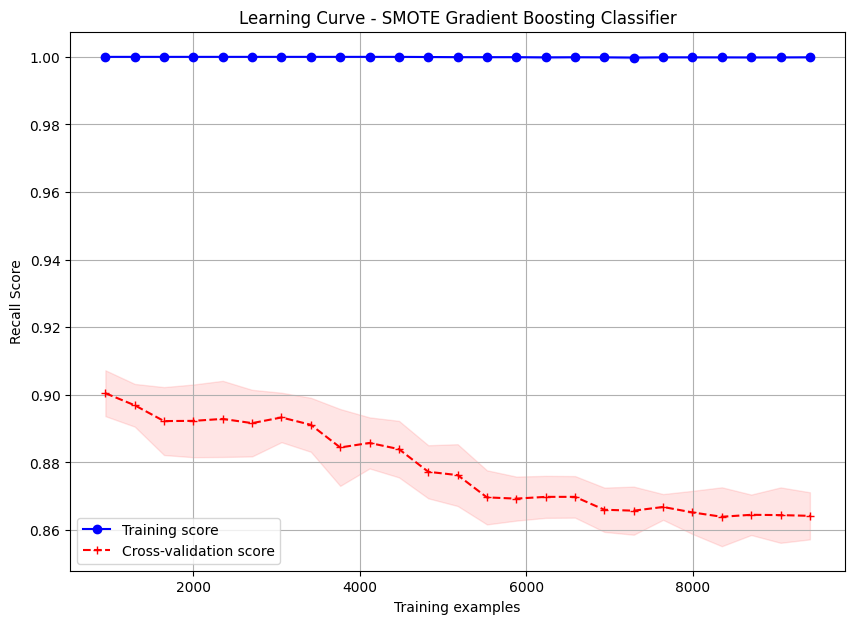

In [48]:
plot_learning_curve(
    train_sizes,
    train_scores,
    test_scores,
    "Learning Curve - SMOTE Gradient Boosting Classifier",
    "Recall"
)

## Stacking Classifier
- Mejores modelos entrega anterior
- Naive Bayes
  - Best: 0.9086887850917319 using {'gaussiannb__var_smoothing': 1.0}
- SGD
  - Best: 0.8589605303285663 using {'sgdclassifier__alpha': 0.1, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'l1'}




In [60]:

naive_bayes_model = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RobustScaler(),
    PowerTransformer("yeo-johnson"),
    PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver="full"),
    GaussianNB(var_smoothing=1.0),
)

sgd_model = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    RobustScaler(),
    PowerTransformer("yeo-johnson"),
    PCA(random_state=RANDOM_STATE, n_components=0.95, svd_solver="full"),
    SGDClassifier(
        random_state=RANDOM_STATE,
        loss="hinge",
        penalty="l1",
        alpha=0.1,
    ),
)

stacking_model = StackingClassifier(
    estimators=[
        ("naive_bayes", naive_bayes_model),
        ("sgd", sgd_model),
    ],
    final_estimator=LogisticRegression(random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('naive_bayes',
                                Pipeline(steps=[('smote',
                                                 SMOTE(random_state=42)),
                                                ('robustscaler',
                                                 RobustScaler()),
                                                ('powertransformer',
                                                 PowerTransformer()),
                                                ('pca',
                                                 PCA(n_components=0.95,
                                                     random_state=42,
                                                     svd_solver='full')),
                                                ('gaussiannb',
                                                 GaussianNB(var_smoothing=1.0))])),
                               ('sgd',
                                Pipeline(steps=[('smote',
                                                 SMOTE(random_state=42)),
                                                ('robustscaler',
                                                 RobustScaler()),
                                                ('powertransformer',
                                                 PowerTransformer()),
                                                ('pca',
                                                 PCA(n_components=0.95,
                                                     random_state=42,
                                                     svd_solver='full')),
                                                ('sgdclassifier',
                                                 SGDClassifier(alpha=0.1,
                                                               penalty='l1',
                                                               random_state=42))]))],
                   final_estimator=LogisticRegression(random_state=42),
                   n_jobs=-1)

In [61]:
y_pred = stacking_model.predict(X_test)
print(recall_score(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

0.9892911779704232
                   pre       rec       spe        f1       geo       iba       sup

          0       0.54      0.16      0.99      0.25      0.40      0.15       452
          1       0.94      0.99      0.16      0.96      0.40      0.17      5883

avg / total       0.91      0.93      0.22      0.91      0.40      0.17      6335



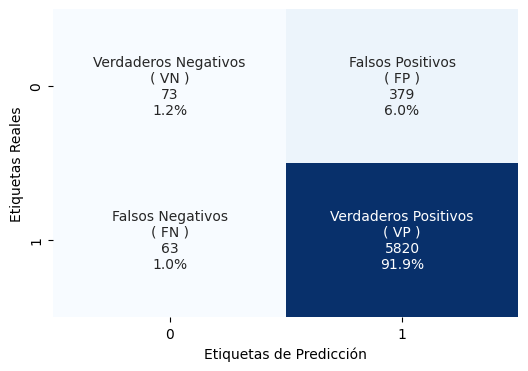

In [62]:
mi_cm(y_test, y_pred)

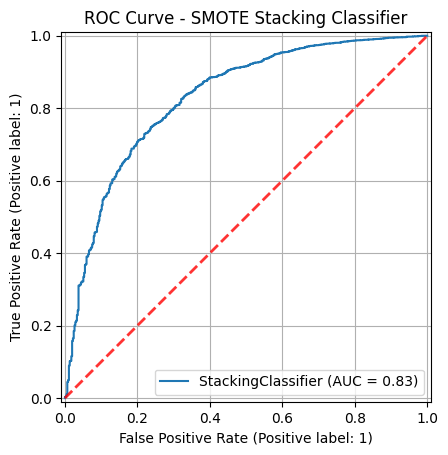

In [63]:
disp = RocCurveDisplay.from_estimator(stacking_model, X_test, y_test)
disp.ax_.grid(True)
disp.ax_.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
# title
disp.ax_.set_title("ROC Curve - SMOTE Stacking Classifier")
plt.show()

In [64]:
train_sizes, train_scores, test_scores = learning_curve(
    stacking_model,
    X_train,
    y_train,
    train_sizes=steps,
    cv=kfold,
    scoring="recall",
    n_jobs=-1
)

<module 'matplotlib.pyplot' from '/home/chango/proyecto-integrador/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

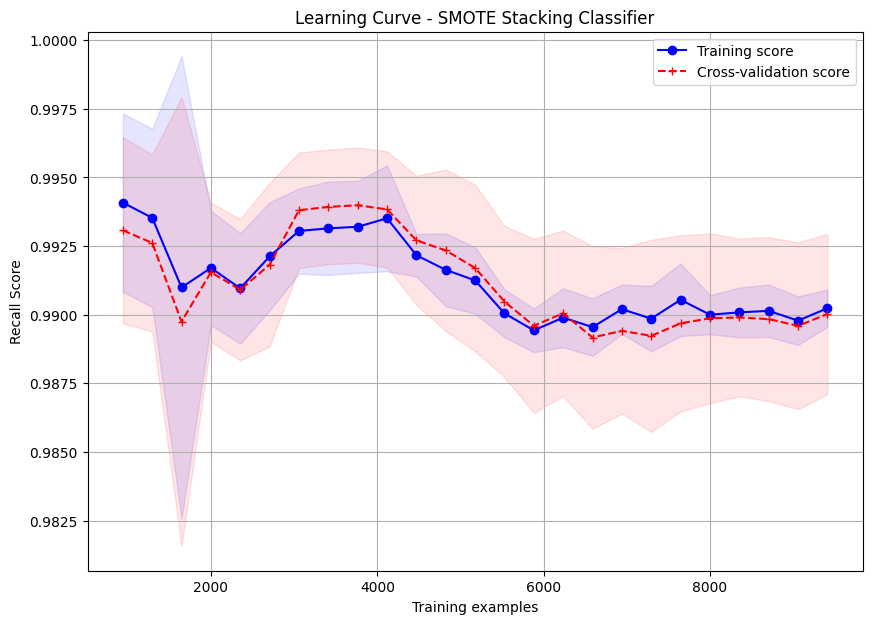

In [65]:
plot_learning_curve(
    train_sizes,
    train_scores,
    test_scores,
    "Learning Curve - SMOTE Stacking Classifier",
    "Recall"
)

# Curvas de calibración

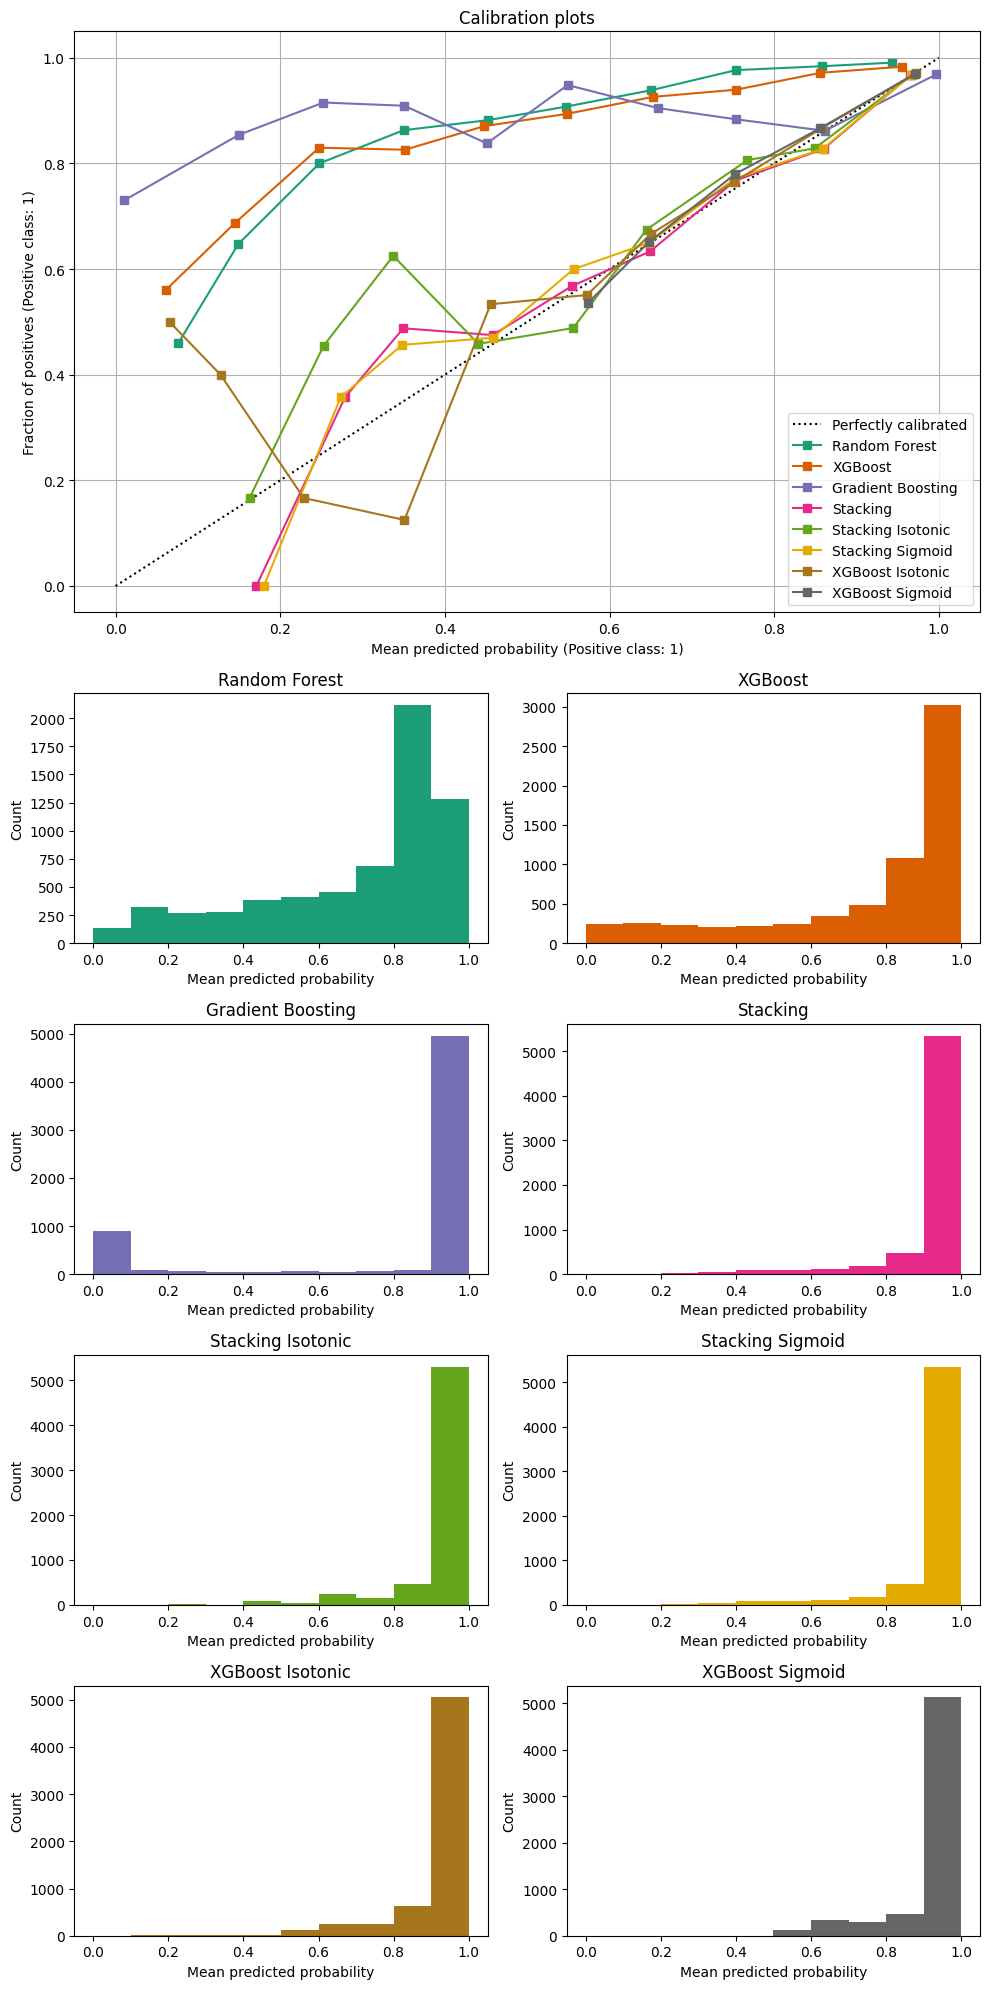

In [96]:
# https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

fig = plt.figure(figsize=(10, 20))
gs = GridSpec(6, 2)
colors = plt.get_cmap("Dark2")

best_stacking_isotonic = CalibratedClassifierCV(stacking_model, cv=5, method="isotonic")
best_stacking_sigmoid  = CalibratedClassifierCV(stacking_model, cv=5, method="sigmoid")

best_xgb_isotonic = CalibratedClassifierCV(best_xgb_model, cv=5, method="isotonic")
best_xgb_sigmoid  = CalibratedClassifierCV(best_xgb_model, cv=5, method="sigmoid")

clf_list =[
    (best_rfc_model,"Random Forest"),
    (best_xgb_model,"XGBoost"),
    (best_gb_model, "Gradient Boosting"),
    (stacking_model,"Stacking"),
    (best_stacking_isotonic, "Stacking Isotonic"),
    (best_stacking_sigmoid, "Stacking Sigmoid"),
    (best_xgb_isotonic, "XGBoost Isotonic"),
    (best_xgb_sigmoid, "XGBoost Sigmoid"),
]

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display


ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1), (5, 0), (5, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")


plt.tight_layout()
plt.show()

# Curvas ROC de todos los modelos




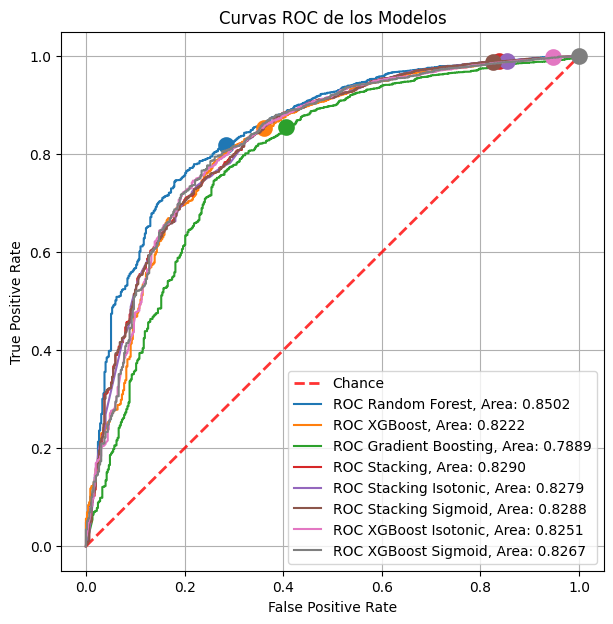

In [105]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.grid()
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

for model, name in clf_list:
    if hasattr(model, "predict_proba"):
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        close_zero = np.argmin(np.abs(thresholds-0.5))
    else:
        fpr, tpr, thresholds = roc_curve(y_test, model.decision_function(X_test))
        close_zero = np.argmin(np.abs(thresholds))

    plt.plot(fpr, tpr, label="ROC {}, Area: {:.4f}".format(name, auc(fpr, tpr)))
    # get last color
    line = ax.get_lines()[-1]
    color = line.get_color()
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, mew=2, label=None, c=color)
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower right", prop={"size": 10})
    plt.title("Curvas ROC de los Modelos")


plt.show()

# Scores de los modelos

In [108]:
final_scores = []
for model, name in clf_list:
    print(f"Evaluating {name}...")
    y_pred = model.predict(X_test)
    final_scores.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "G-Mean": geometric_mean_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_pred),
        "Brier Score Loss": brier_score_loss(y_test, y_pred),
    })

Evaluating Random Forest...
Evaluating XGBoost...
Evaluating Gradient Boosting...
Evaluating Stacking...
Evaluating Stacking Isotonic...
Evaluating Stacking Sigmoid...
Evaluating XGBoost Isotonic...
Evaluating XGBoost Sigmoid...


In [109]:
scores_df = pd.DataFrame(
    final_scores,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "G-Mean", "ROC AUC", "Brier Score Loss"]
)
scores_df.style.highlight_max(color = 'lightgreen', axis = 0)
# sort by lower brier score loss
scores_df.sort_values(by=["Brier Score Loss", "Recall", "F1"], ascending=True)

,Model,Accuracy,Precision,Recall,F1,G-Mean,ROC AUC,Brier Score Loss
5,Stacking Sigmoid,0.9309,0.9398,0.9890,0.9637,0.4157,0.5819,0.0691
4,Stacking Isotonic,0.9304,0.9379,0.9907,0.9635,0.3803,0.5683,0.0696
3,Stacking,0.9302,0.9389,0.9893,0.9634,0.3997,0.5754,0.0698
6,XGBoost Isotonic,0.9302,0.9320,0.9976,0.9637,0.2302,0.5254,0.0698
7,XGBoost Sigmoid,0.9287,0.9287,1.0000,0.9630,0.0000,0.5000,0.0713
1,XGBoost,0.8380,0.9686,0.8533,0.9073,0.7386,0.7463,0.1620
2,Gradient Boosting,0.8366,0.9649,0.8552,0.9067,0.7134,0.7252,0.1634
0,Random Forest,0.8125,0.9741,0.8198,0.8903,0.7666,0.7683,0.1875


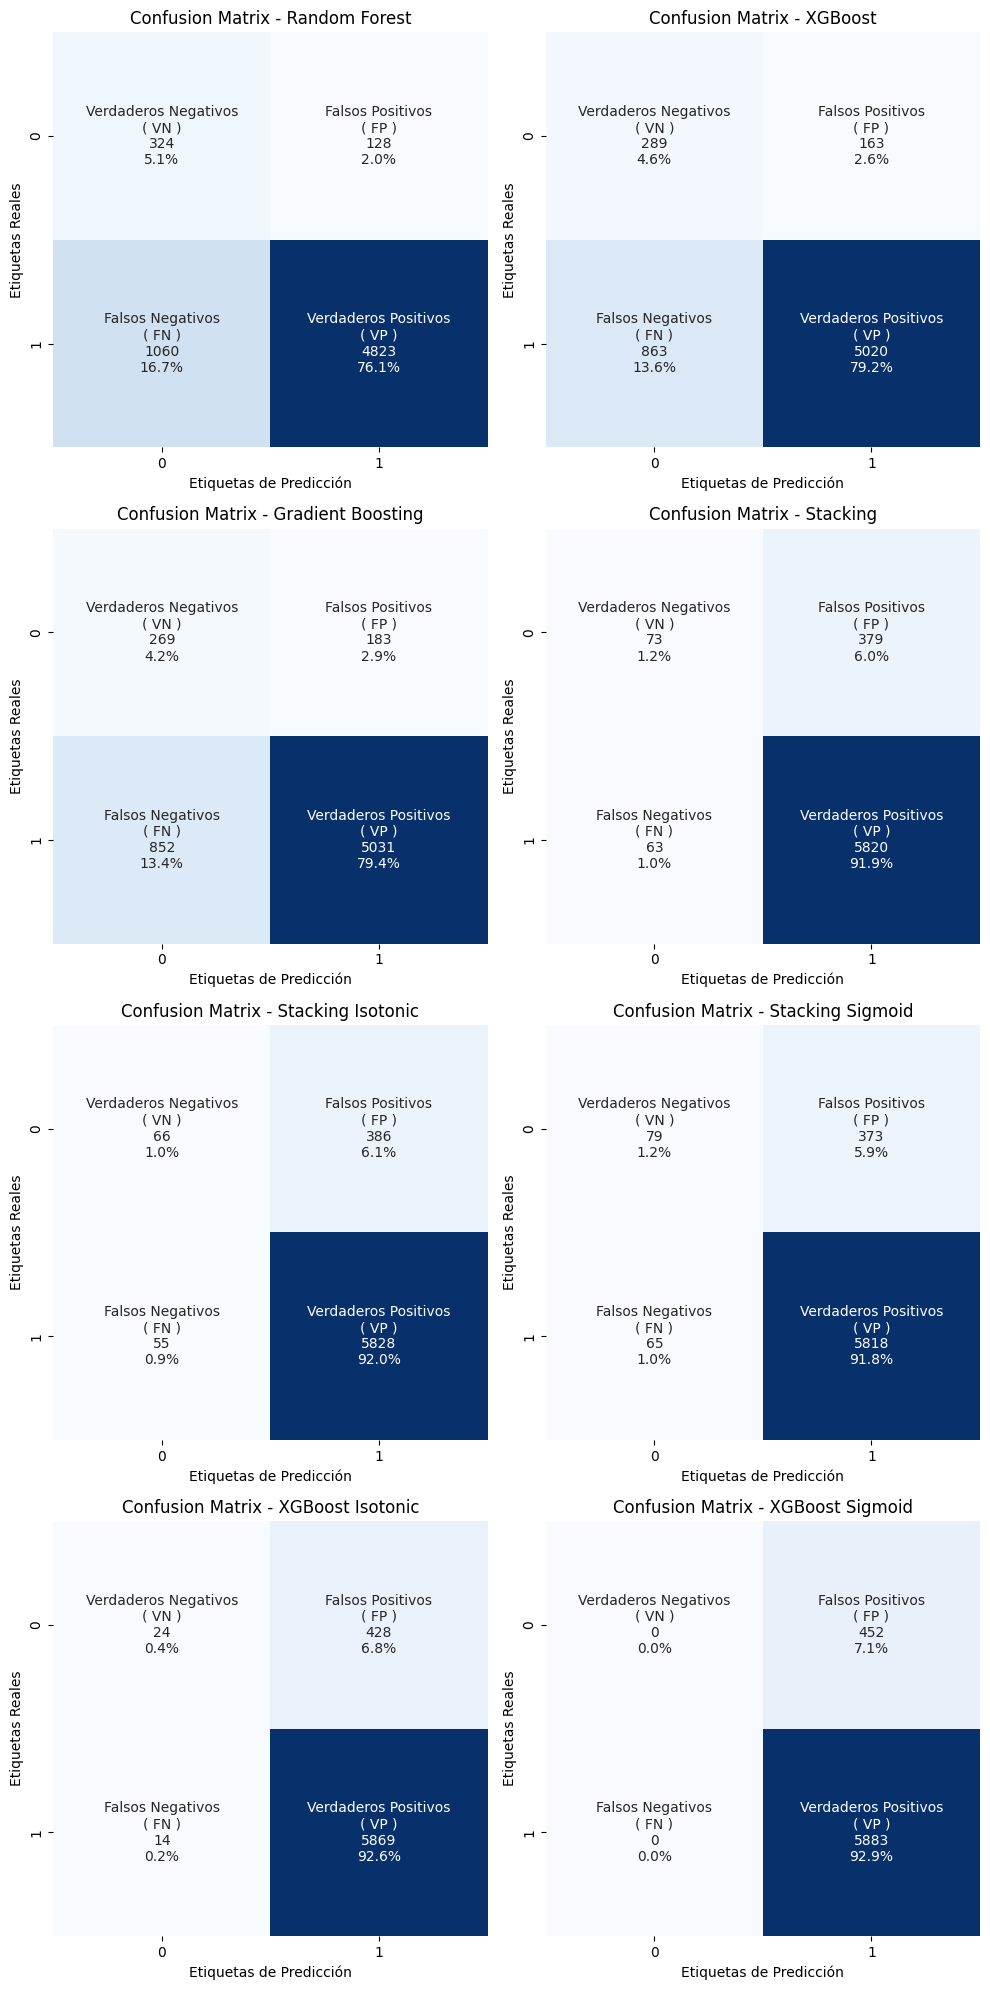

In [118]:
# matrices de confusión de todos los modelos
fig, ax = plt.subplots(4, 2, figsize=(10, 20))
ax = ax.ravel()

for i, (model, name) in enumerate(clf_list):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    txt = [
        "Verdaderos Negativos",
        "Falsos Positivos",
        "Falsos Negativos",
        "Verdaderos Positivos",
    ]
    vf = ["( VN )", "( FP )", "( FN )", "( VP )"]
    frecuencia = ["{0:0.0f}".format(value) for value in cm.flatten()]
    porcentaje = ["{0:.1%}".format(value) for value in cm.flatten() / np.sum(cm)]

    labels = [
        f"{v1}\n{v2}\n{v3}\n{v4}"
        for v1, v2, v3, v4 in zip(txt, vf, frecuencia, porcentaje)
    ]
    labels = np.asarray(labels).reshape(2, 2)



    sns.heatmap(cm, annot=labels, fmt="", cmap="Blues", ax=ax[i], cbar=False)
    ax[i].set_title(f"Confusion Matrix - {name}")
    ax[i].set_xlabel("Etiquetas de Predicción")
    ax[i].set_ylabel("Etiquetas Reales")

plt.tight_layout()
plt.show()


In [110]:
import joblib
# save all models
joblib.dump(best_rfc_model, "models/best_rfc_model.pkl")
joblib.dump(best_xgb_model, "models/best_xgb_model.pkl")
joblib.dump(best_gb_model, "models/best_gb_model.pkl")
joblib.dump(stacking_model, "models/stacking_model.pkl")
joblib.dump(best_stacking_isotonic, "models/best_stacking_isotonic.pkl")
joblib.dump(best_stacking_sigmoid, "models/best_stacking_sigmoid.pkl")
joblib.dump(best_xgb_isotonic, "models/best_xgb_isotonic.pkl")
joblib.dump(best_xgb_sigmoid, "models/best_xgb_sigmoid.pkl")


['models/best_xgb_sigmoid.pkl']

# Probando los mejores modelos con usuarios nuevos no vistos en el entrenamiento
- los usuarios nuevos no vistos, son usuarios registrados en la misma plataforma desde el 1ero de enero del 2024 al dia 25 de febrero del 2024
- Siempre que tengan más de 30 días de registro

In [226]:
# cargar datos de producción
prod_df = pd.read_csv("data/prod-pickwin-active-users.csv")
clean_prod_df = prod_df.dropna()
clean_prod_df = clean_prod_df.drop_duplicates()
clean_prod_df = clean_prod_df[(clean_prod_df.T != 0).any()]


In [227]:
clean_prod_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,260.0000,"201,009.4115",399.9399,"200,455.0000","200,674.5000","200,895.5000","201,341.2500","201,889.0000"
purchases_count,260.0000,2.0538,4.8591,0.0000,1.0000,1.0000,2.0000,53.0000
purchases_amount,260.0000,"6,042.9038","33,599.2470",0.0000,50.0000,250.0000,512.5000,"409,633.0000"
cashouts_count,260.0000,0.2731,0.9416,0.0000,0.0000,0.0000,0.0000,9.0000
cashouts_amount,260.0000,"2,012.7238","10,575.5261",0.0000,0.0000,0.0000,0.0000,"93,164.0000"
total_bets,260.0000,10.4038,34.1055,1.0000,1.0000,2.0000,7.0000,404.0000
winning_bets,260.0000,3.6846,17.8706,0.0000,0.0000,1.0000,1.0000,257.0000
losing_bets,260.0000,6.4077,18.5429,0.0000,0.0000,1.0000,4.2500,147.0000
total_risk,260.0000,"33,346.4675","162,464.4201",0.0000,69.0000,340.0000,"1,315.5000","1,807,131.0000"
total_win,260.0000,"30,008.5118","140,151.0031",0.0000,0.0000,60.4000,"1,004.2050","1,487,479.6500"


In [228]:

# feature generation
clean_prod_df["net_winnings"] = clean_prod_df.apply(
    lambda x: x["net_win"] if x["net_win"] > 0 else 0, axis=1
)
clean_prod_df["net_losses"] = clean_prod_df.apply(
    lambda x: x["net_win"] if x["net_win"] < 0 else 0, axis=1
).abs()
# clean_prod_df["winner"] = np.where(clean_prod_df["net_win"] > 0, 1, 0)

# relation of winning bets to total bets
clean_prod_df["win_ratio"] = clean_prod_df["winning_bets"] / clean_prod_df["total_bets"]
# relation of risked money to total bets
clean_prod_df["risk_per_bet"] = clean_prod_df["total_risk"] / clean_prod_df["total_bets"]
# relation of net winnings to total bets
clean_prod_df["net_winnings_per_bet"] = clean_prod_df["net_winnings"] / clean_prod_df["total_bets"]
# relation of net losses to total bets
clean_prod_df["net_losses_per_bet"] = clean_prod_df["net_losses"] / clean_prod_df["total_bets"]

clean_prod_df['real_churned'] = np.where(clean_prod_df['days_since_last_bet'] > 30, 1, 0)
# drop days_since_last_bet
clean_prod_df = clean_prod_df.drop(columns=["days_since_last_bet"])



In [229]:
# nulls?
clean_prod_df.isnull().sum()

id                      0
purchases_count         0
purchases_amount        0
cashouts_count          0
cashouts_amount         0
total_bets              0
winning_bets            0
losing_bets             0
total_risk              0
total_win               0
net_win                 0
net_winnings            0
net_losses              0
win_ratio               0
risk_per_bet            0
net_winnings_per_bet    0
net_losses_per_bet      0
real_churned            0
dtype: int64

In [230]:
clean_prod_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,260.0000,"201,009.4115",399.9399,"200,455.0000","200,674.5000","200,895.5000","201,341.2500","201,889.0000"
purchases_count,260.0000,2.0538,4.8591,0.0000,1.0000,1.0000,2.0000,53.0000
purchases_amount,260.0000,"6,042.9038","33,599.2470",0.0000,50.0000,250.0000,512.5000,"409,633.0000"
cashouts_count,260.0000,0.2731,0.9416,0.0000,0.0000,0.0000,0.0000,9.0000
cashouts_amount,260.0000,"2,012.7238","10,575.5261",0.0000,0.0000,0.0000,0.0000,"93,164.0000"
total_bets,260.0000,10.4038,34.1055,1.0000,1.0000,2.0000,7.0000,404.0000
winning_bets,260.0000,3.6846,17.8706,0.0000,0.0000,1.0000,1.0000,257.0000
losing_bets,260.0000,6.4077,18.5429,0.0000,0.0000,1.0000,4.2500,147.0000
total_risk,260.0000,"33,346.4675","162,464.4201",0.0000,69.0000,340.0000,"1,315.5000","1,807,131.0000"
total_win,260.0000,"30,008.5118","140,151.0031",0.0000,0.0000,60.4000,"1,004.2050","1,487,479.6500"


In [231]:
clean_prod_df

,id,purchases_count,purchases_amount,cashouts_count,cashouts_amount,total_bets,winning_bets,losing_bets,total_risk,total_win,net_win,net_winnings,net_losses,win_ratio,risk_per_bet,net_winnings_per_bet,net_losses_per_bet,real_churned
11,200455,1,"11,000.0000",0,0.0000,6.0000,2.0000,4.0000,"25,004.7400","3,025.0000","-21,979.7400",0.0000,"21,979.7400",0.3333,"4,167.4567",0.0000,"3,663.2900",1
16,200460,1,50.0000,0,0.0000,1.0000,0.0000,1.0000,78.0000,28.8000,-49.2000,0.0000,49.2000,0.0000,78.0000,0.0000,49.2000,1
22,200466,2,100.0000,0,0.0000,9.0000,0.0000,9.0000,100.0000,0.0000,-100.0000,0.0000,100.0000,0.0000,11.1111,0.0000,11.1111,1
29,200473,1,56.0000,0,0.0000,1.0000,0.0000,1.0000,124.0000,70.4000,-53.6000,0.0000,53.6000,0.0000,124.0000,0.0000,53.6000,1
40,200484,1,250.0000,0,0.0000,2.0000,0.0000,1.0000,250.0000,0.0000,-250.0000,0.0000,250.0000,0.0000,125.0000,0.0000,125.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,201836,1,50.0000,0,0.0000,3.0000,0.0000,3.0000,60.0000,11.4000,-48.6000,0.0000,48.6000,0.0000,20.0000,0.0000,16.2000,0
1393,201841,1,"5,000.0000",0,0.0000,2.0000,0.0000,2.0000,"10,023.0000",0.0000,"-10,023.0000",0.0000,"10,023.0000",0.0000,"5,011.5000",0.0000,"5,011.5000",0
1427,201875,1,100.0000,0,0.0000,3.0000,0.0000,3.0000,160.0000,60.2000,-99.8000,0.0000,99.8000,0.0000,53.3333,0.0000,33.2667,0
1440,201888,1,100.0000,0,0.0000,7.0000,2.0000,5.0000,"1,984.0000","1,886.4000",-97.6000,0.0000,97.6000,0.2857,283.4286,0.0000,13.9429,0


In [232]:
# real_churned counts
clean_prod_df["real_churned"].value_counts()

real_churned
1    184
0     76
Name: count, dtype: int64

In [233]:
Xprod, y_real = clean_prod_df.drop(["real_churned", "id"], axis=1), clean_prod_df["real_churned"]

In [234]:
Xprod.shape, y_real.shape

((260, 16), (260,))

In [242]:
# check if the models are still good
production_scores = []

for model, name in clf_list:


    y_pred = model.predict(Xprod)
    production_scores.append({
        "Model": name,
        "Accuracy": accuracy_score(y_real, y_pred),
        "Precision": precision_score(y_real, y_pred),
        "Recall": recall_score(y_real, y_pred),
        "F1": f1_score(y_real, y_pred),
        "G-Mean": geometric_mean_score(y_real, y_pred),
        "ROC AUC": roc_auc_score(y_real, y_pred),
        "Brier Score Loss": brier_score_loss(y_real, y_pred),
    })




In [243]:
production_scores_df = pd.DataFrame(
    production_scores,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "G-Mean", "ROC AUC", "Brier Score Loss"]
)

production_scores_df.style.highlight_max(color = 'lightgreen', axis = 0)
# sort by lower brier score loss
production_scores_df.sort_values(by=["Brier Score Loss", "Recall", "F1"], ascending=True)

,Model,Accuracy,Precision,Recall,F1,G-Mean,ROC AUC,Brier Score Loss
1,XGBoost,0.7654,0.7573,0.9837,0.8558,0.4827,0.6103,0.2346
0,Random Forest,0.7577,0.7574,0.9674,0.8496,0.4918,0.6087,0.2423
2,Gradient Boosting,0.7269,0.7534,0.9130,0.8256,0.5023,0.5947,0.2731
3,Stacking,0.7231,0.7188,1.0000,0.8364,0.2294,0.5263,0.2769
4,Stacking Isotonic,0.7231,0.7188,1.0000,0.8364,0.2294,0.5263,0.2769
5,Stacking Sigmoid,0.7231,0.7188,1.0000,0.8364,0.2294,0.5263,0.2769
6,XGBoost Isotonic,0.7077,0.7077,1.0000,0.8288,0.0000,0.5000,0.2923
7,XGBoost Sigmoid,0.7077,0.7077,1.0000,0.8288,0.0000,0.5000,0.2923


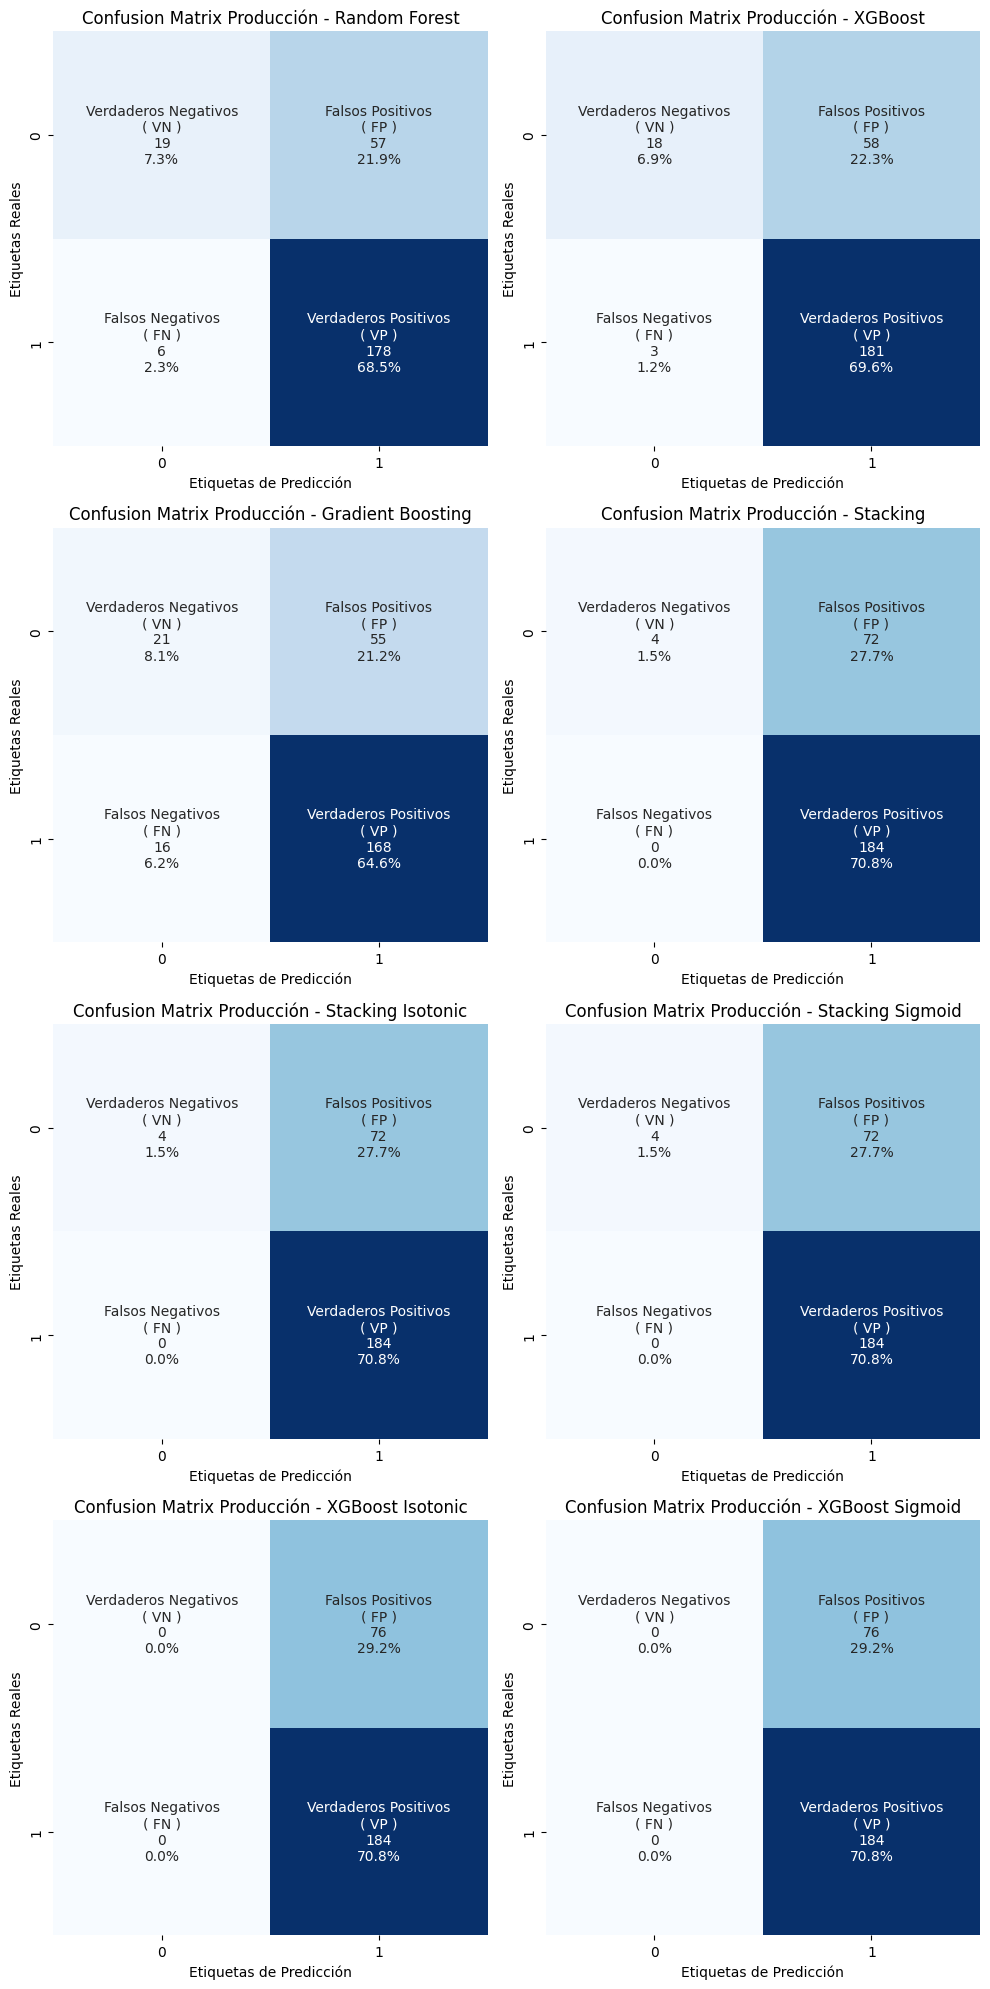

In [245]:
fig, ax = plt.subplots(4, 2, figsize=(10, 20))
ax = ax.ravel()

for i, (model, name) in enumerate(clf_list):
    y_pred = model.predict(Xprod)
    cm = confusion_matrix(y_real, y_pred)

    txt = [
        "Verdaderos Negativos",
        "Falsos Positivos",
        "Falsos Negativos",
        "Verdaderos Positivos",
    ]
    vf = ["( VN )", "( FP )", "( FN )", "( VP )"]
    frecuencia = ["{0:0.0f}".format(value) for value in cm.flatten()]
    porcentaje = ["{0:.1%}".format(value) for value in cm.flatten() / np.sum(cm)]

    labels = [
        f"{v1}\n{v2}\n{v3}\n{v4}"
        for v1, v2, v3, v4 in zip(txt, vf, frecuencia, porcentaje)
    ]
    labels = np.asarray(labels).reshape(2, 2)



    sns.heatmap(cm, annot=labels, fmt="", cmap="Blues", ax=ax[i], cbar=False)
    ax[i].set_title(f"Confusion Matrix Producción - {name}")
    ax[i].set_xlabel("Etiquetas de Predicción")
    ax[i].set_ylabel("Etiquetas Reales")

plt.tight_layout()
plt.show()

# Conclusiones

Train Times

RandomForestClassifier 36.2s #RandomizedSearchCV

XGBoost 16.7s #RandomizedSearchCV

GradientBoostingClassifier 7m 15.3s #GridSearchCV

StackingClassifier #no grid search